In [6]:
import rasterio
from rasterio.features import shapes
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
from matplotlib.colors import LightSource
import geopandas as gpd
import requests
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import open3d as o3d
import matplotlib.pyplot as plt
import seaborn as sns
import fiona
import pycrs
import json
import pprint
import plotly.graph_objs as go
import plotly.express as px
from datetime import datetime

In [7]:
datas = {'MNT_LIEGE'  : '/media/bestycame/407C5CD57C5CC776/3D/RELIEF_WALLONIE_MNT_2013_2014_LIEGE.tif',
         'MNT_HAINAUT': 'TBD',
         'MNS_LIEGE'  : '/media/bestycame/407C5CD57C5CC776/3D/RELIEF_WALLONIE_MNS_2013_2014_LIEGE.tif',
         'MNS_HAINAUT': 'TBD'}

In [8]:
# gdal_calc.py -A DSM/GeoTIFF/DHMVII_DSM_1m_testdata.tif -B ./dtm_1m.tif --outfile=CHM.tif --calc="A-B" --NoDataValue=0
# gdalwarp  DTM/GeoTIFF/DHMVII_DTM_5m_testdata.tif test.tif -tr 1 1 -r near
# gdal_contour -3d -a elev chm.tif contour.shp -i 0.5 -snodata 0b

In [ ]:
gdb = fiona.open('./BATI3D_2013-2014_FILEGDB_31370/BATI3D_2013-2014.gdb', layer=1)
hits = list(gdb.items(bbox=(xMin, yMin, xMax, yMax)))
meshes = []
for hit in hits:
    points = hit[1]['geometry']['coordinates']
    pts = [item for sublist in points for sitem in sublist for item in sitem]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    mesh = pcd.compute_convex_hull()
    meshes.append(mesh[0])
o3d.visualization.draw_geometries(meshes, point_show_normal=True, mesh_show_wireframe=True, mesh_show_back_face=True)

In [9]:
# Christophe Schenke 
# christophe.shanke@spw.walonnie.be  
# 0475 95 4570

In [10]:
from pyproj import Transformer
def lambert_to_wgs(x_lambert, y_lambert):
    transformer = Transformer.from_crs("epsg:31370", "epsg:4326")
    x_wgs, y_wgs = transformer.transform(x_lambert, y_lambert)
    return x_wgs, y_wgs

def wgs_to_lambert(x_wgs, y_wgs):
    transformer = Transformer.from_crs("epsg:4326", "epsg:31370")
    x_lambert, y_lambert = transformer.transform(x_wgs, y_wgs)
    return x_lambert, y_lambert

# x, y, xMin, xMax, yMin, yMax = search_address(cp='5000', rue='RUE DE LA CRETE', num = '111', as_wgs=False)
def search_address(cp, rue, num, as_wgs=False, as_dict=False, boundary=False):    
    url = 'http://geoservices.wallonie.be/geolocalisation/rest/getPositionByCpRueAndNumero/{cp}/{rue}/{num}'
    r = requests.get(url.format(cp=cp, rue=rue, num=num)).json()
    x, y, xMin, xMax, yMin, yMax = r['x'], r['y'], r['rue']['xMin'], r['rue']['xMax'], r['rue']['yMin'], r['rue']['yMax']
    if as_wgs:
        x, y       = lambert_to_wgs(x, y)
        xMin, xMax = lambert_to_wgs(xMin, xMax)
        yMin, yMax = lambert_to_wgs(yMin, yMax)
    if as_dict:
        return {'x': x, 'xMin': xMin, 'xMax': xMax, 
                'y': y, 'yMin': yMin, 'yMax': yMax}
    return x, y, xMin, xMax, yMin, yMax

#x, y, xMin, xMax, yMin, yMax = search_address_mapbox("Rue du roton 38, 6000 Charleroi", as_wgs=False, boundary=150)
def search_address_mapbox(address, as_wgs=False, as_dict=False, boundary=100):
    key = 'pk.eyJ1IjoiYmFjYXlhdzU1OSIsImEiOiJja2dtNTgyNW8wMWN2MnBzM2loNGt4NmlzIn0.3IYulU7qzfpq2Ms0aaYWMQ'
    url = "https://api.mapbox.com/geocoding/v5/mapbox.places/{address}.json?types=address&access_token={key}"
    r = requests.get(url.format(address=address,key=key))
    if r.status_code != 200:
        return 'NotFound'
    r = r.json()
    y, x = r['features'][0]['center']
    x, y = wgs_to_lambert(x, y)
    xMin, xMax = x - boundary, x + boundary
    yMin, yMax = y - boundary, y + boundary
    if as_wgs:
        x, y       = lambert_to_wgs(x, y)
        xMin, xMax = lambert_to_wgs(xMin, xMax)
        yMin, yMax = lambert_to_wgs(yMin, yMax) 
    if as_dict:
        return {'x': x, 'xMin': xMin, 'xMax': xMax, 
                'y': y, 'yMin': yMin, 'yMax': yMax}
    return x, y, xMin, xMax, yMin, yMax

def is_in_bbox(x, y, xMin, yMin, xMax, yMax):
    if xMin <= x <= xMax and  yMin <= y <= yMax:
        return True
    return False

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def subsetTif(xMin, xMax, yMin, yMax, in_tif, out_tif=None):
    if out_tif == None:
        out_tif = datetime.now().strftime('%Y%m%d_%H%M%S.%f') + '.tif'
    data = rasterio.open(in_tif)
    geo = gpd.GeoDataFrame({'geometry': box(xMin, yMin, xMax, yMax)}, index=[0], crs=from_epsg(31370))
    out_img, out_transform = mask(dataset=data, shapes=getFeatures(geo), filled=False, crop=True)
    out_meta = data.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform})
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
    return out_tif

#show_tif('subset.tif', title=address, hillshade=False)
def show_tif(tif, title=None, hillshade=False):
    if title == None:
        title = tif
    colors = [[0.0, 'rgb(000, 063, 076)'], [0.1, 'rgb(029, 081, 059)'], [0.2, 'rgb(055, 098, 043)'], 
             [0.3, 'rgb(079, 114, 030)'], [0.4, 'rgb(103, 129, 016)'], [0.5, 'rgb(136, 142, 002)'], 
             [0.6, 'rgb(169, 154, 021)'], [0.7, 'rgb(192, 171, 045)'], [0.8, 'rgb(214, 188, 074)'],
             [0.9, 'rgb(234, 209, 112)'], [1.0, 'rgb(254, 229, 152)']]
    
    with rasterio.open(tif) as src:
        data = src.read(1)

    if hillshade:
        light = LightSource(azdeg=315, altdeg=45)
        data = light.hillshade(data, vert_exag=1)     

    fig = px.imshow(data, color_continuous_scale=colors)
    fig.update_traces(customdata=data, hovertemplate='elevation: %{customdata:.4f}')
    fig.update_layout(**dict(title_text=title, width=700, height=500, template='none'))
    return fig

def create_chm(xMin, xMax, yMin, yMax):
    out_file = datetime.now().strftime('%Y%m%d_%H%M%S.%f') + '.tif'
    mnt = subsetTif(xMin, xMax, yMin, yMax, datas['MNT_LIEGE'])
    mns = subsetTif(xMin, xMax, yMin, yMax, datas['MNS_LIEGE'])
    !gdal_calc.py -A $mns -B $mnt --outfile=$out_file --calc="A-B" --NoDataValue -9999
    return out_file

CPU times: user 967 ms, sys: 31.2 ms, total: 998 ms
Wall time: 1.13 s


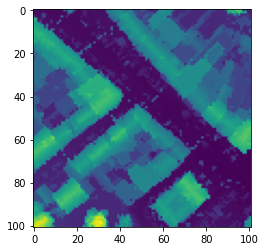

In [39]:
%%time
address = "Place Henri Hallet Hannut"
x, y, xMin, xMax, yMin, yMax = search_address_mapbox(address, as_wgs=False, boundary=50)
tiff = subsetTif(xMin, xMax, yMin, yMax, in_tif=datas['MNS_LIEGE'])
with rasterio.open(tiff) as src:
        data = src.read(1)
plt.imshow(data)

In [41]:
show_tif('20210625_091634.035220.tif', title=address, hillshade=False)